## Reconmmendations

The code should explicitly:

1) return the performance of the algorithms tested using the appropriate metric

2) explain with markdown comment important modelling decisions including metric selection

3) generate a csv file with the predictions

Performance is not the main goal.

The first objective of the project is to write the main steps of a data-science project with a proper style and well written comments.

The algorithms used do not have to be hyper-optimized on all parameters. However, the project should test different algorithms adapted to the type of problem.

The target for this project is TARGET_FLAG
The files SHELL_AUTO and MEAN_AUTO can be ignored for this project.



In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns
from re import sub
import numpy as np
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
import itertools
import scipy.stats as ss


## 1. Read Data

In [2]:
train_df = pd.read_csv('./data/auto-insurance-fall-2017/train_auto.csv')
test_df = pd.read_csv('./data/auto-insurance-fall-2017/test_auto.csv')

train_df.drop(columns=['INDEX'], inplace=True)
test_df.drop(columns=['INDEX'], inplace=True)

In [3]:
train_df.shape

(8161, 25)

In [4]:
test_df.shape

(2141, 25)

In [5]:
train_df.head()

TARGET_FLAG  TARGET_AMT  KIDSDRIV   AGE  HOMEKIDS   YOJ    INCOME PARENT1  \
0            0         0.0         0  60.0         0  11.0   $67,349      No   
1            0         0.0         0  43.0         0  11.0   $91,449      No   
2            0         0.0         0  35.0         1  10.0   $16,039      No   
3            0         0.0         0  51.0         0  14.0       NaN      No   
4            0         0.0         0  50.0         0   NaN  $114,986      No   

   HOME_VAL MSTATUS  SEX      EDUCATION            JOB  TRAVTIME     CAR_USE  \
0        $0    z_No    M            PhD   Professional        14     Private   
1  $257,252    z_No    M  z_High School  z_Blue Collar        22  Commercial   
2  $124,191     Yes  z_F  z_High School       Clerical         5     Private   
3  $306,251     Yes    M   <High School  z_Blue Collar        32     Private   
4  $243,925     Yes  z_F            PhD         Doctor        36     Private   

  BLUEBOOK  TIF CAR_TYPE RED_CAR OLDCLAIM  CLM_FREQ REVOKED  MVR_PTS  CAR_AGE  \
0  $14,230   11  Minivan     yes   $4,461         2      No        3     18.0   
1  $14,940    1  Minivan     yes       $0         0      No        0      1.0   
2   $4,010    4    z_SUV      no  $38,690         2      No        3     10.0   
3  $15,440    7  Minivan     yes       $0         0      No        0      6.0   
4  $18,000    1    z_SUV      no  $19,217         2     Yes        3     17.0   

            URBANICITY  
0  Highly Urban/ Urban  
1  Highly Urban/ Urban  
2  Highly Urban/ Urban  
3  Highly Urban/ Urban  
4  Highly Urban/ Urban

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   object 
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   object 
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   object 
 19  OLDCLA

In [7]:
train_df['TARGET_FLAG'].value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

In [8]:
2153/6008

0.3583555259653795

**Comment** 

Slightly imbalanced data. 

## 2. Clean Data

In [9]:
train_df.select_dtypes(include=['object']).head()

INCOME PARENT1  HOME_VAL MSTATUS  SEX      EDUCATION            JOB  \
0   $67,349      No        $0    z_No    M            PhD   Professional   
1   $91,449      No  $257,252    z_No    M  z_High School  z_Blue Collar   
2   $16,039      No  $124,191     Yes  z_F  z_High School       Clerical   
3       NaN      No  $306,251     Yes    M   <High School  z_Blue Collar   
4  $114,986      No  $243,925     Yes  z_F            PhD         Doctor   

      CAR_USE BLUEBOOK CAR_TYPE RED_CAR OLDCLAIM REVOKED           URBANICITY  
0     Private  $14,230  Minivan     yes   $4,461      No  Highly Urban/ Urban  
1  Commercial  $14,940  Minivan     yes       $0      No  Highly Urban/ Urban  
2     Private   $4,010    z_SUV      no  $38,690      No  Highly Urban/ Urban  
3     Private  $15,440  Minivan     yes       $0      No  Highly Urban/ Urban  
4     Private  $18,000    z_SUV      no  $19,217     Yes  Highly Urban/ Urban

**Comment:** 

The main cleaning tasks are:

1) Convert monetary values that are in string form to float

2) Convert boolean values that are in string form to boolean

3) Encode categorical variables

In [10]:


def convert_monetary_str_to_float(s):
    if s != s:
        return 0.0
    return np.float(sub(r'[^\d.]', '', s))
    
# def convert_yes_no_str_to_boolean(s):
#     if s != s:
#         return s
#     if 'yes' in s.lower():
#         return True
#     return False
    

In [11]:
cols_monetary = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
# cols_boolean = ['PARENT1', 'MSTATUS', 'RED_CAR', 'REVOKED']
cols_cat = ['SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'URBANICITY', 'PARENT1', 'MSTATUS', 'RED_CAR', 'REVOKED']

In [12]:
for col in cols_monetary:
    train_df[col] = train_df[col].apply(lambda x : convert_monetary_str_to_float(x))
    test_df[col] = test_df[col].apply(lambda x : convert_monetary_str_to_float(x))

# for col in cols_boolean:
#     train_df[col] = train_df[col].apply(lambda x : convert_yes_no_str_to_boolean(x))
#     test_df[col] = test_df[col].apply(lambda x : convert_yes_no_str_to_boolean(x))




In [13]:
for col in cols_cat:
    print(train_df[col].value_counts())

z_F    4375
M      3786
Name: SEX, dtype: int64
z_High School    2330
Bachelors        2242
Masters          1658
<High School     1203
PhD               728
Name: EDUCATION, dtype: int64
z_Blue Collar    1825
Clerical         1271
Professional     1117
Manager           988
Lawyer            835
Student           712
Home Maker        641
Doctor            246
Name: JOB, dtype: int64
Private       5132
Commercial    3029
Name: CAR_USE, dtype: int64
z_SUV          2294
Minivan        2145
Pickup         1389
Sports Car      907
Van             750
Panel Truck     676
Name: CAR_TYPE, dtype: int64
Highly Urban/ Urban      6492
z_Highly Rural/ Rural    1669
Name: URBANICITY, dtype: int64
No     7084
Yes    1077
Name: PARENT1, dtype: int64
Yes     4894
z_No    3267
Name: MSTATUS, dtype: int64
no     5783
yes    2378
Name: RED_CAR, dtype: int64
No     7161
Yes    1000
Name: REVOKED, dtype: int64


**Comment:**  

Categorical variables seem pretty clean (No wrong/repeated encodings etc), will ignore the random prefix (e.g.z_) for now

## 3. Missing Data

In [14]:
train_df.isna().sum()

TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME           0
PARENT1          0
HOME_VAL         0
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

<AxesSubplot:>

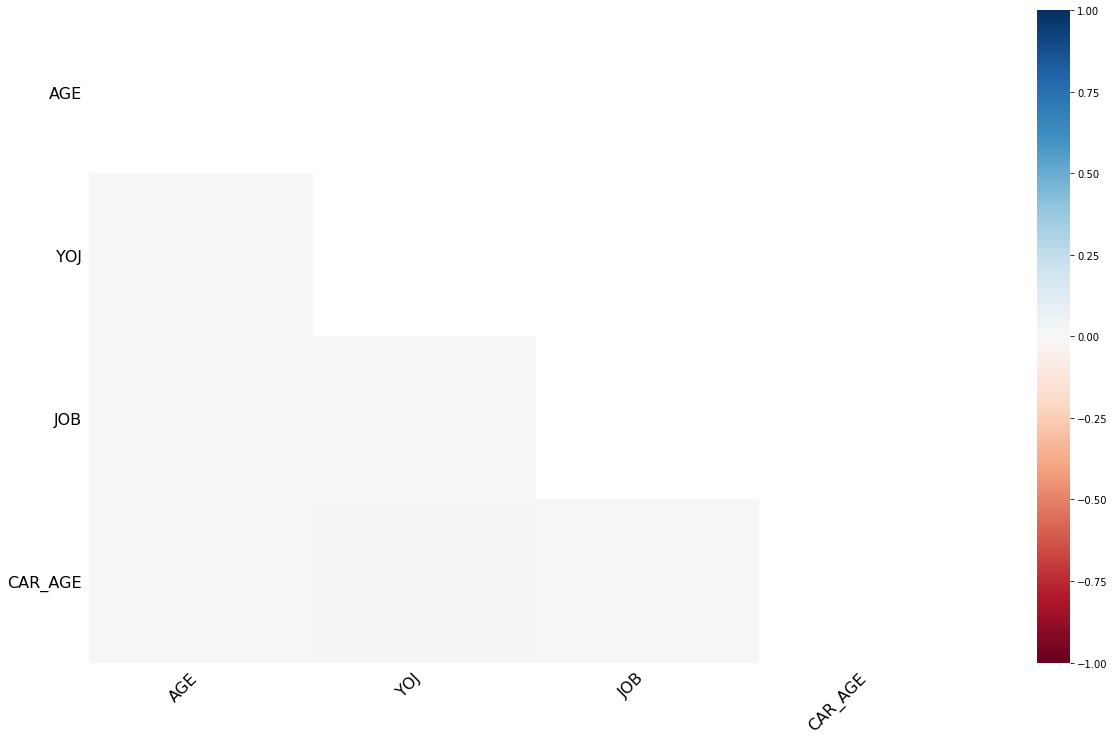

In [15]:
msno.heatmap(train_df)

In [16]:
test_df.isna().sum()

TARGET_FLAG    2141
TARGET_AMT     2141
KIDSDRIV          0
AGE               1
HOMEKIDS          0
YOJ              94
INCOME            0
PARENT1           0
HOME_VAL          0
MSTATUS           0
SEX               0
EDUCATION         0
JOB             139
TRAVTIME          0
CAR_USE           0
BLUEBOOK          0
TIF               0
CAR_TYPE          0
RED_CAR           0
OLDCLAIM          0
CLM_FREQ          0
REVOKED           0
MVR_PTS           0
CAR_AGE         129
URBANICITY        0
dtype: int64

<AxesSubplot:>

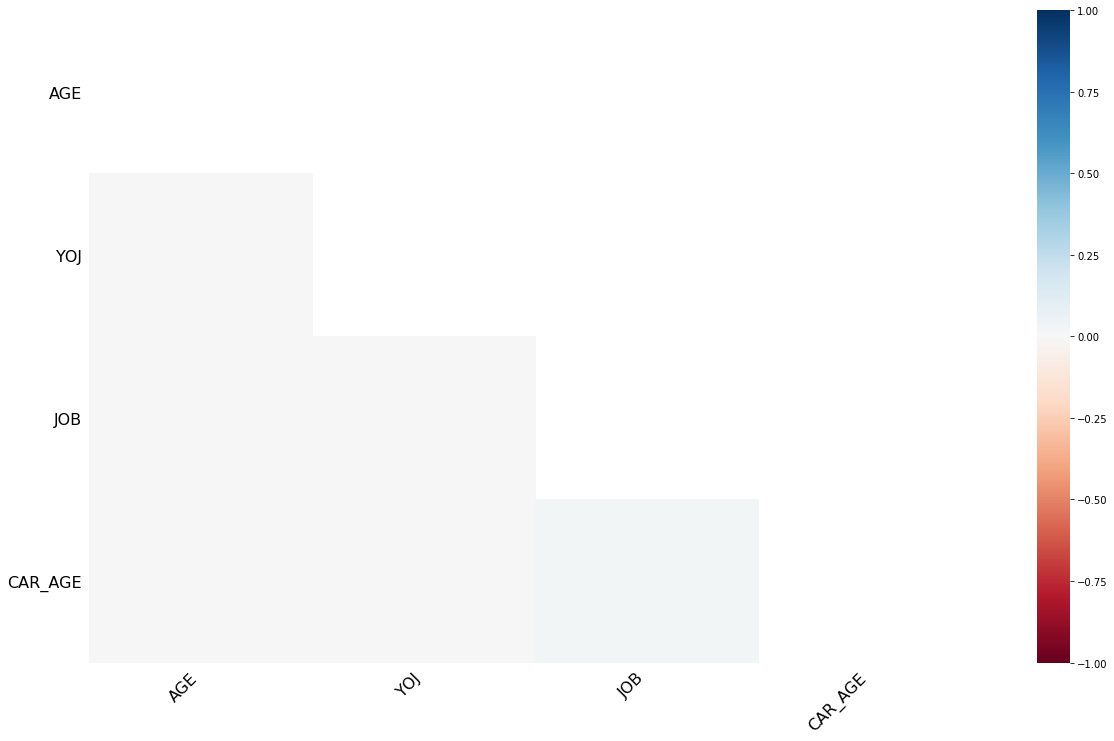

In [17]:
msno.heatmap(test_df)

**Comment:** 

Common missing values are from the features of:

1) AGE

2) YOJ

3) INCOME (only missing in test)

4) HOME_VAL (only missing in test)

5) JOB

6) CAR_AGE

There do not seem to be any correlation between the absence of one feature and another.


Since the proportion of missing values are not that big, we can drop them, or fill them, or handling them using algorithims that are robust to missing values. 


## 5. Processing data



In [18]:
train_y = train_df[['TARGET_FLAG']]
train_x = train_df.drop(columns=['TARGET_FLAG'])

In [19]:
# 1) Standardize numerical columns 

features_continuous = train_x.select_dtypes(include=[np.number]).columns

scaler = MinMaxScaler()
train_x[features_continuous] = scaler.fit_transform(train_x[features_continuous])

In [20]:
# 2) Dummy encode categrocial columns

features_categorical = train_x.select_dtypes(include=['object']).columns
train_x = pd.get_dummies(train_x, columns = cols_cat)

In [21]:
train_x.head()

TARGET_AMT  KIDSDRIV       AGE  HOMEKIDS       YOJ    INCOME  HOME_VAL  \
0         0.0       0.0  0.676923       0.0  0.478261  0.183497  0.000000   
1         0.0       0.0  0.415385       0.0  0.478261  0.249159  0.290588   
2         0.0       0.0  0.292308       0.2  0.434783  0.043699  0.140284   
3         0.0       0.0  0.538462       0.0  0.608696  0.000000  0.345936   
4         0.0       0.0  0.523077       0.0       NaN  0.313288  0.275534   

   TRAVTIME  BLUEBOOK       TIF  OLDCLAIM  CLM_FREQ   MVR_PTS   CAR_AGE  \
0  0.065693  0.186547  0.416667  0.078212       0.4  0.230769  0.677419   
1  0.124088  0.196952  0.000000  0.000000       0.0  0.000000  0.129032   
2  0.000000  0.036782  0.125000  0.678332       0.4  0.230769  0.419355   
3  0.197080  0.204279  0.250000  0.000000       0.0  0.000000  0.290323   
4  0.226277  0.241794  0.000000  0.336922       0.4  0.230769  0.645161   

   SEX_M  SEX_z_F  EDUCATION_<High School  EDUCATION_Bachelors  \
0      1        0                       0                    0   
1      1        0                       0                    0   
2      0        1                       0                    0   
3      1        0                       1                    0   
4      0        1                       0                    0   

   EDUCATION_Masters  EDUCATION_PhD  EDUCATION_z_High School  JOB_Clerical  \
0                  0              1                        0             0   
1                  0              0                        1             0   
2                  0              0                        1             1   
3                  0              0                        0             0   
4                  0              1                        0             0   

   JOB_Doctor  JOB_Home Maker  JOB_Lawyer  JOB_Manager  JOB_Professional  \
0           0               0           0            0                 1   
1           0               0           0            0                 0   
2           0               0           0            0                 0   
3           0               0           0            0                 0   
4           1               0           0            0                 0   

   JOB_Student  JOB_z_Blue Collar  CAR_USE_Commercial  CAR_USE_Private  \
0            0                  0                   0                1   
1            0                  1                   1                0   
2            0                  0                   0                1   
3            0                  1                   0                1   
4            0                  0                   0                1   

   CAR_TYPE_Minivan  CAR_TYPE_Panel Truck  CAR_TYPE_Pickup  \
0                 1                     0                0   
1                 1                     0                0   
2                 0                     0                0   
3                 1                     0                0   
4                 0                     0                0   

   CAR_TYPE_Sports Car  CAR_TYPE_Van  CAR_TYPE_z_SUV  \
0                    0             0               0   
1                    0             0               0   
2                    0             0               1   
3                    0             0               0   
4                    0             0               1   

   URBANICITY_Highly Urban/ Urban  URBANICITY_z_Highly Rural/ Rural  \
0                               1                                 0   
1                               1                                 0   
2                               1                                 0   
3                               1                                 0   
4                               1                                 0   

   PARENT1_No  PARENT1_Yes  MSTATUS_Yes  MSTATUS_z_No  RED_CAR_no  \
0           1            0            0             1           0   
1           1            0            0       

## 5. Examine feature correlations

/Users/ziwang/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


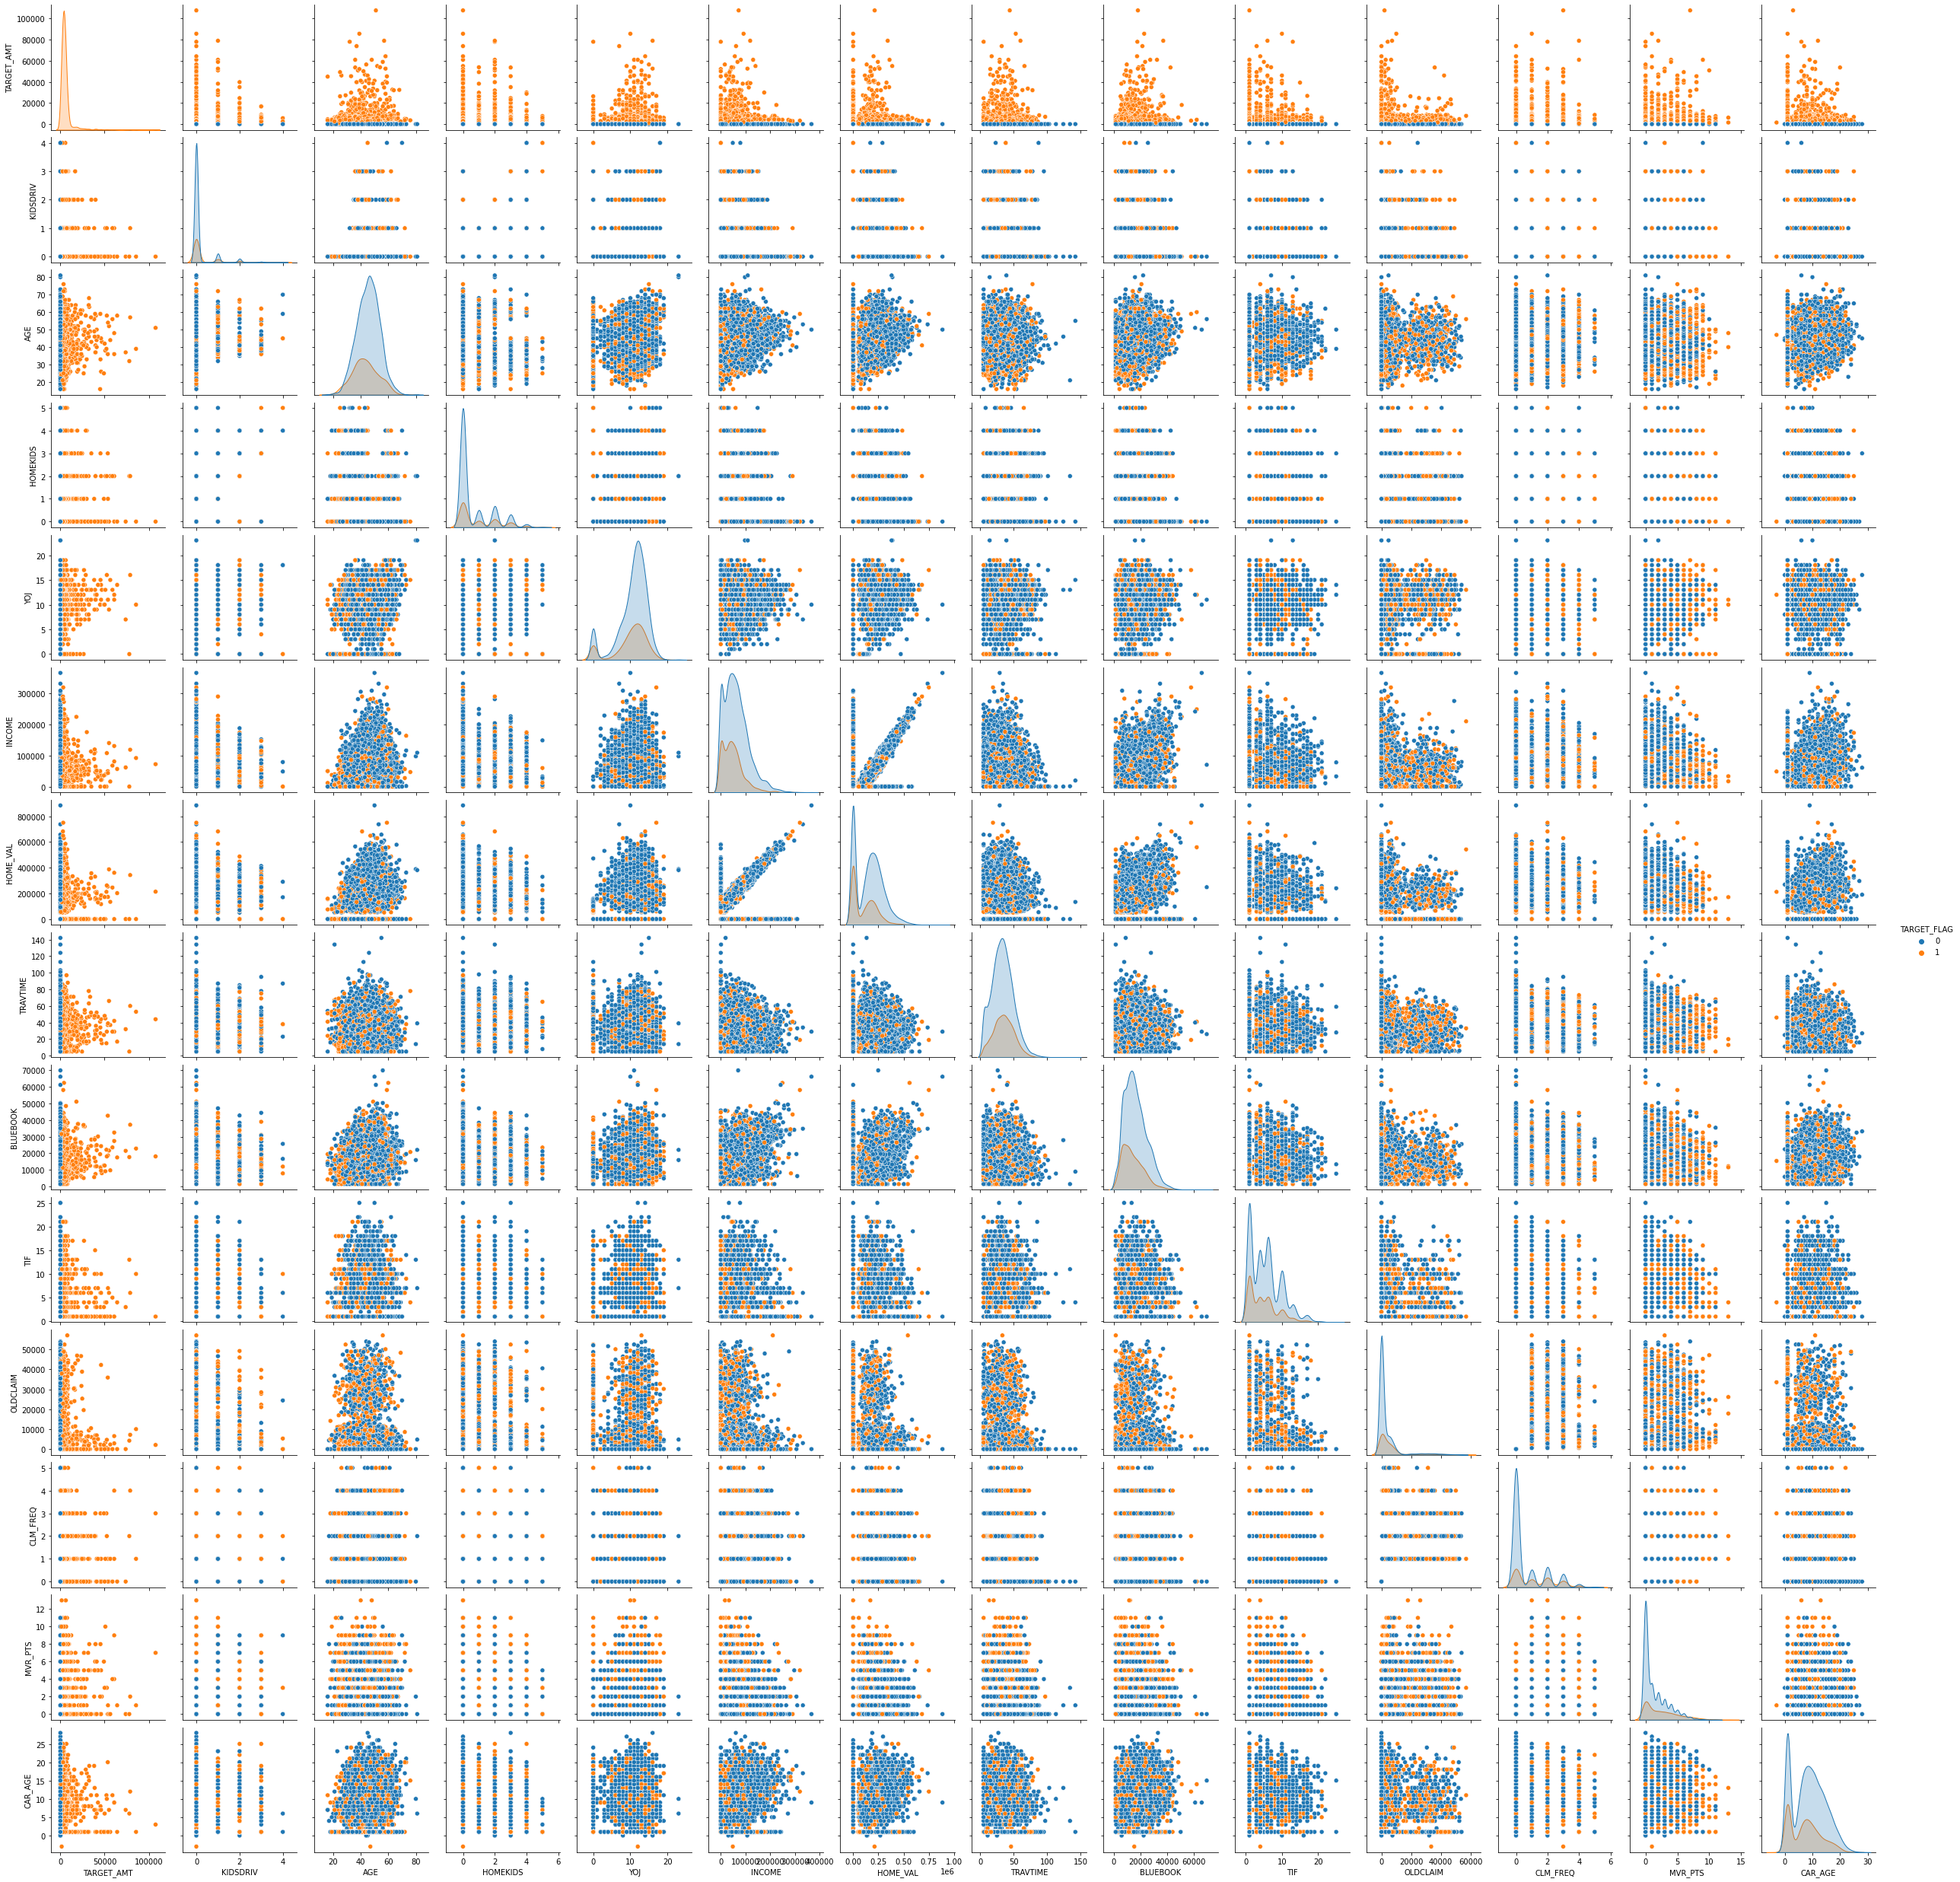

In [22]:
sns.pairplot(train_df, hue="TARGET_FLAG")

**Comment:** 

Looking at numerical features, the distribution of target given each numerical feature (diagnol) are not well separated. naive metrics such as accuracy is not suitable.

For some features it is hard to say if they are ordinal or continuous. Will treat them as continuous so unseen values from test data, if any, will not break the model. 

the feature 'TARGET_AMT' will produce a perfect seperation. It is likely that this is only non-zero if  TARGET_FLAG is known to be 1. It should be removed from prediction features.

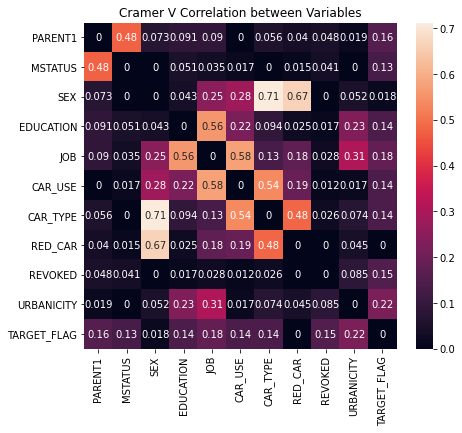

In [23]:


def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = train_df.select_dtypes(['object']).columns.to_list() + ['TARGET_FLAG']
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(train_df[col1], train_df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

**Comment:** 

Looking at categorical features, associations are not very strong. 

URBANICITY  0.22

REVOKED 0.15

JOB 0.18

PARENT1 0.16

CAR_USE/CAR_TYPE 0.14




## Modeling

see next notebook